In [1]:
import numpy as np
from scipy.special import hankel2
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, RickerSource, Receiver, TimeAxis, AcquisitionGeometry
from devito import set_log_level
from benchmarks.user.tools.plotter import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1

# Verification

We compute the error between the numerical and reference solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the error for these parameters.

In [3]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)

# Domain sizes and gird spacing
shapes = ((201, 2.0), (161, 2.5), (101, 4.0))
dx = [2.0, 2.5, 4.0]
nshapes = len(shapes)

# Number of time steps
nt = 1501
# Time axis
dt = 0.1
t0 = 0.
tn = dt * (nt-1)
time = np.linspace(0., 150., nt)
print("t0, tn, dt, nt; %.4f %.4f %.4f %d" % (t0, tn, dt, nt))
# Source peak frequency
f0 = .07

t0, tn, dt, nt; 0.0000 150.0000 0.1000 1501


In [4]:
# Fine grid model
c0 = 1.5
model = ModelBench(vp=c0, origin=(0., 0.), spacing=(.5, .5), 
                   shape=(801, 801), space_order=20, nbl=40, dtype=np.float64)

Operator `initdamp` run in 0.01 s


In [5]:
# Source and receiver geometries
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = 200.

# single receiver offset 100 m from source
rec_coordinates = np.empty((1, 2))
rec_coordinates[:, :] = 260.

print("Grid: ", model.grid)
print("Source coordinates: ", src_coordinates)
print("Receiver coordinates: ", rec_coordinates)
    
# note: gets time sampling from model.critical_dt
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                               t0=t0, tn=tn, src_type='Ricker', f0=f0)

Grid:  Grid[extent=(440.0, 440.0), shape=(881, 881), dimensions=(x, y)]
Source coordinates:  [[200. 200.]]
Receiver coordinates:  [[260. 260.]]


# Reference solution for numerical convergence

In [6]:
solver = AcousticWaveSolver(model, geometry, time_order=2, space_order=20)
ref_rec, ref_u, _ = solver.forward()

# scale the reference data to match analytic solution
ref_rec.data[:] = 1e2 * ref_rec.data[:] / (model.spacing[0]*c0)**2
ref_u.data[:] = 1e2 * ref_u.data[:] / (model.spacing[0]*c0)**2

Operator `Forward` run in 10.32 s


# Analytical solution for comparison with the reference numerical solution

The analytical solution of the 2D acoustic wave-equation with a source pulse is defined as:

$$
u_s(r, t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \{ -i \pi H_0^{(2)}\left(k r \right) q(\omega) e^{i\omega t} d\omega\}
$$

$$
r = \sqrt{(x - x_{src})^2+(y - y_{src})^2}
$$

where $H_0^{(2)}$ is the Hankel function of the second kind, $F(\omega)$ is the Fourier spectrum of the source time function at angular frequencies $\omega$ and $k = \frac{\omega}{v}$ is the wavenumber.

We look at the analytical and numerical solution at a single grid point. We ensure that this grid point is on-the-grid for all discretizations analyised in the further verification.

In [7]:
# Source and receiver coordinates
sx, sz = src_coordinates[0, :]
rx, rz = rec_coordinates[0, :]

# Define an Ricker wavelet shifted to zero lag for the Fourier transform
def ricker(f, T, dt, t0):
    t = np.linspace(-t0, T-t0, int(T/dt))
    tt = (np.pi**2) * (f**2) * (t**2)
    y = 1e2*(1.0 - 2.0 * tt) * np.exp(- tt)
    return y

def analytical(nt, model, time, **kwargs):
    dt = kwargs.get('dt', model.critical_dt)
    # Fourier constants
    nf = int(nt/2 + 1)
    fnyq = 1. / (2 * dt)
    df = 1.0 / time[-1]
    faxis = df * np.arange(nf)

    rick = ricker(f0, time[-1], dt, 1.0/f0)

    # Take the Fourier transform ofthe source time-function
    R = np.fft.fft(rick/(c0**2))
    R = R[0:nf]
    nf = len(R)

    # Compute the Hankel function and multiply by the source spectrum
    U_a = np.zeros((nf), dtype=complex)
    for a in range(1, nf-1):
        k = 2 * np.pi * faxis[a] / c0
        tmp = k * np.sqrt(((rx - sx))**2 + ((rz - sz))**2)
        U_a[a] = -1j * np.pi * hankel2(0.0, tmp) * R[a]

    # Do inverse fft on 0:dt:T and you have analytical solution
    U_t = 1.0/(2.0 * np.pi) * np.real(np.fft.ifft(U_a[:], nt))
    return np.real(U_t)

In [8]:
time1 = np.linspace(0.0, 3000., 30001)
U_t = analytical(30001, model, time1, dt=time1[1] - time1[0])
U_t = U_t[0:1501]

In [9]:
print("Numerical data min,max,abs; %+12.6f %+12.6f %+12.6f" % 
      (np.min(ref_rec.data), np.max(ref_rec.data), np.max(np.abs(ref_rec.data)) ))
print("Analytic  data min,max,abs; %+12.6f %+12.6f %+12.6f" % 
      (np.min(U_t), np.max(U_t), (np.max(np.abs(U_t)))))

Numerical data min,max,abs;    -1.074192    +1.722292    +1.722292
Analytic  data min,max,abs;    -1.071499    +1.723489    +1.723489


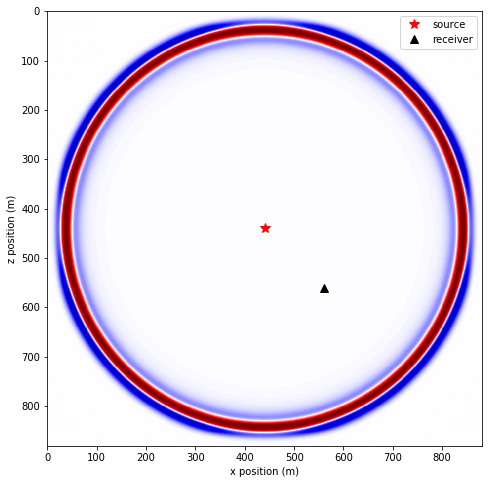

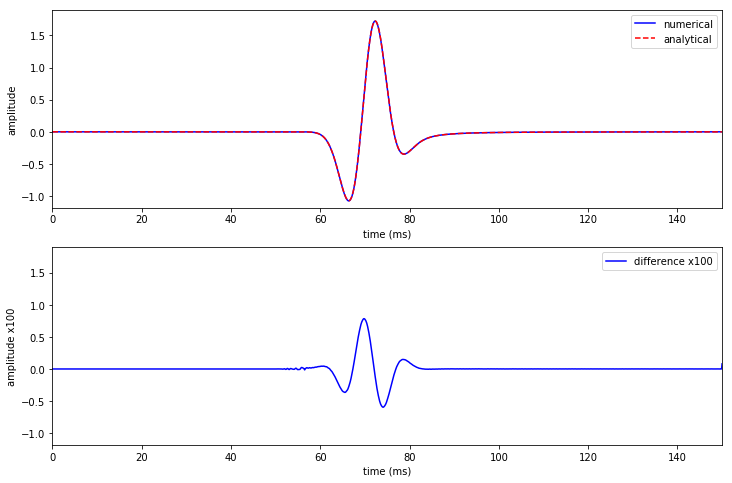

In [10]:
# Plot wavefield and source/rec position
plt.figure(figsize=(8,8))
plt.imshow(ref_u.data[1,:,:], vmin=-1., vmax=1., cmap="seismic")
plt.plot(2*sx+40, 2*sz+40, 'r*', markersize=11, label='source') # plot position of the source in model, add nbl for correct position
plt.plot(2*rx+40, 2*rz+40, 'k^', markersize=8, label='receiver')  # plot position of the receiver in model, add nbl for correct position
plt.legend()
plt.xlabel('x position (m)')
plt.ylabel('z position (m)')
plt.savefig('wavefieldperf.pdf')

# Plot trace
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(time, ref_rec.data[:, 0], '-b', label='numerical')
plt.plot(time, U_t[:], '--r', label='analytical')
plt.xlim([0,150])
plt.ylim([1.1*np.min(U_t[:]), 1.1*np.max(U_t[:])])
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()
plt.subplot(2,1,2)
plt.plot(time, 100 * (ref_rec.data[:, 0] - U_t[:]), '-b', label='difference x100')
plt.xlim([0,150])
plt.ylim([1.1*np.min(U_t[:]), 1.1*np.max(U_t[:])])
plt.xlabel('time (ms)')
plt.ylabel('amplitude x100')
plt.legend()
plt.savefig('ref.pdf')
plt.show()

In [11]:
error_time = np.zeros(5)
error_time[0] = np.linalg.norm(U_t[:-1] - ref_rec.data[:-1, 0], 2) / np.sqrt(nt)
print(error_time[0])

0.0013036865068737533


# Convergence in time


We first show the convergence of the time discretization for a fix high-order spatial discretization (20th order).

After we show that the time discretization converges in $O(dt^2)$ and therefore only contains the error in time, we will take the numerical solution for `dt=.1ms` as a reference for the spatial discretization analysis.



In [12]:
dt = [.1, 0.08, .075, 0.0625, .05]
nnt = [1501, 1876, 2001, 2401, 3001]

for i in range(1, 5):
    # Time axis
    t0 = 0.0
    tn = 150.0
    time = np.linspace(t0, tn, nnt[i])

    # Source geometry
    src_coordinates = np.empty((1, 2))
    src_coordinates[0, :] = 200.

    # single receiver offset 100 m from source
    rec_coordinates = np.empty((1, 2))
    rec_coordinates[:, :] = 260.

    geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                                   t0=t0, tn=tn, src_type='Ricker', f0=f0)

    # note incorrct data size will be generated here due to AcquisitionGeometry bug ... 
    # temporarily fixed below by resizing the output from the solver
    geometry.resample(dt[i])
    print("geometry.time_axes; ", geometry.time_axis)
    
    solver = AcousticWaveSolver(model, geometry, time_order=2, space_order=20)
    ref_rec1, ref_u1, _ = solver.forward(dt=dt[i])
    ref_rec1_data = ref_rec1.data[0:nnt[i],:]

    # scale the reference data to match analytic solution
    ref_rec1_data[:] = 1e2 * ref_rec1_data[:] / (model.spacing[0]*c0)**2

    time1 = np.linspace(0.0, 3000., 20*(nnt[i]-1) + 1)
    U_t1 = analytical(20*(nnt[i]-1) + 1, model, time1, dt=time1[1] - time1[0])
    U_t1 = U_t1[0:nnt[i]]

    error_time[i] = np.linalg.norm(U_t1[:-1] - ref_rec1_data[:-1, 0], 2) / np.sqrt(nnt[i])
    print("error for dt=%.4f is %6f \n" % (dt[i], error_time[i]))

geometry.time_axes;  TimeAxis: start=0, stop=150.08, step=0.08, num=1877


Operator `Forward` run in 11.87 s


error for dt=0.0800 is 0.000872 

geometry.time_axes;  TimeAxis: start=0, stop=150, step=0.075, num=2001


Operator `Forward` run in 16.29 s


error for dt=0.0750 is 0.000778 

geometry.time_axes;  TimeAxis: start=0, stop=150, step=0.0625, num=2401


Operator `Forward` run in 20.28 s


error for dt=0.0625 is 0.000565 

geometry.time_axes;  TimeAxis: start=0, stop=150, step=0.05, num=3001


Operator `Forward` run in 24.85 s


error for dt=0.0500 is 0.000386 



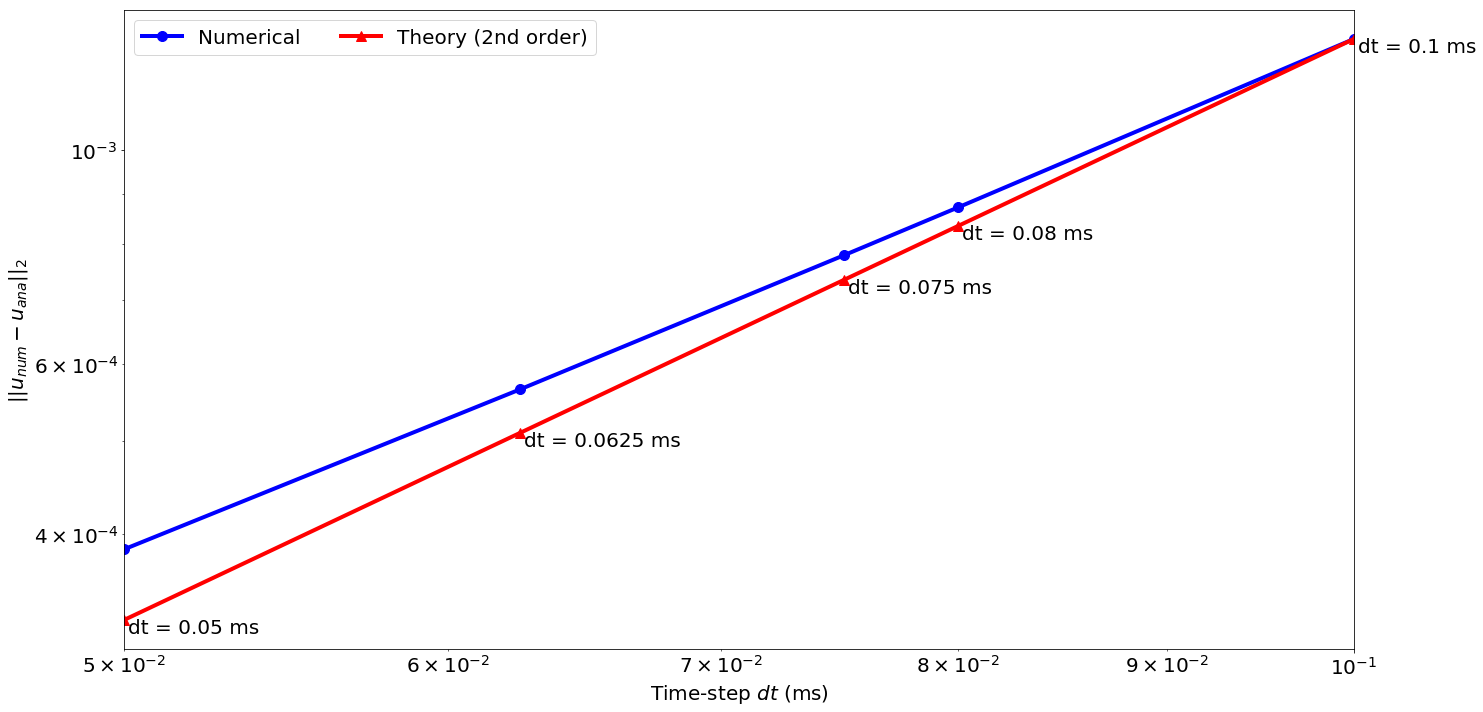

In [13]:
dt = [.1, 0.08, .075, 0.0625, .05]

plt.figure(figsize=(20, 10))
theory = [t**2 for t in dt]
theory = [error_time[0]*th/theory[0] for th in theory]
plt.loglog([t for t in dt], error_time, '-ob', label=('Numerical'), linewidth=4, markersize=10)
plt.loglog([t for t in dt], theory, '-^r', label=('Theory (2nd order)'), linewidth=4, markersize=10)
for x, y, a in zip([t for t in dt], theory, [('dt = %s ms' % (t)) for t in dt]):
            plt.annotate(a, xy=(x, y), xytext=(4, 2),
                         textcoords='offset points', size=20,
                         horizontalalignment='left', verticalalignment='top')
plt.xlabel("Time-step $dt$ (ms)", fontsize=20)
plt.ylabel("$|| u_{num} - u_{ana}||_2$", fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.xlim((0.05, 0.1))
plt.legend(fontsize=20, ncol=4, fancybox=True, loc='best')
plt.savefig("TimeConvergence.pdf", format='pdf', facecolor='white',
            orientation='landscape', bbox_inches='tight')
plt.show()

In [14]:
np.polyfit(np.log([t for t in dt]), np.log(error_time), deg=1)

array([ 1.75601297, -2.60578388])

# Convergence in space
We have a correct reference solution we can use for space discretization analysis

In [15]:
errorl2 = np.zeros((norder, nshapes))
timing = np.zeros((norder, nshapes))

set_log_level("ERROR")
ind_o = -1
for spc in orders:
    ind_o +=1
    ind_spc = -1
    for nn, h in shapes:
        ind_spc += 1
        time = np.linspace(0., 150., nt)

        model = ModelBench(vp=c0, origin=(0., 0.), spacing=(h, h), 
                           shape=(nn, nn), space_order=spc, nbl=40, dtype=np.float64)

        # Source geometry
        src_coordinates = np.empty((1, 2))
        src_coordinates[0, :] = 200.

        # single receiver offset 100 m from source
        rec_coordinates = np.empty((1, 2))
        rec_coordinates[:, :] = 260.

        geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                                       t0=t0, tn=tn, src_type='Ricker', f0=f0)

        solver = AcousticWaveSolver(model, geometry, time_order=2, space_order=spc)
        loc_rec, loc_u, summary = solver.forward()

        # scale the reference data to match analytic solution
        loc_rec.data[:] = 1e2 * loc_rec.data[:] / (h*c0)**2

        # Compare to reference solution
        errorl2[ind_o, ind_spc] = np.linalg.norm(loc_rec.data[:-1, 0] - U_t[:-1], np.inf)
        timing[ind_o, ind_spc] = np.max([v for _, v in summary.timings.items()])
        print("starting space order %s with (%s, %s) grid points the error is %s for %s seconds runtime" %
              (spc, nn, nn, errorl2[ind_o, ind_spc], timing[ind_o, ind_spc]))

starting space order 2 with (201, 201) grid points the error is 0.5928060720257116 for 0.29188700000000173 seconds runtime
starting space order 2 with (161, 161) grid points the error is 0.9240546509319004 for 0.22975100000000287 seconds runtime
starting space order 2 with (101, 101) grid points the error is 1.6633364900685317 for 0.10834999999999886 seconds runtime
starting space order 4 with (201, 201) grid points the error is 0.03125589059901901 for 0.33659100000000103 seconds runtime
starting space order 4 with (161, 161) grid points the error is 0.08544188030464883 for 0.22754099999999244 seconds runtime
starting space order 4 with (101, 101) grid points the error is 0.5283550594711399 for 0.15757099999999974 seconds runtime
starting space order 6 with (201, 201) grid points the error is 0.005921188662591392 for 0.45181899999999897 seconds runtime
starting space order 6 with (161, 161) grid points the error is 0.01121505340584572 for 0.3391360000000002 seconds runtime
starting spa

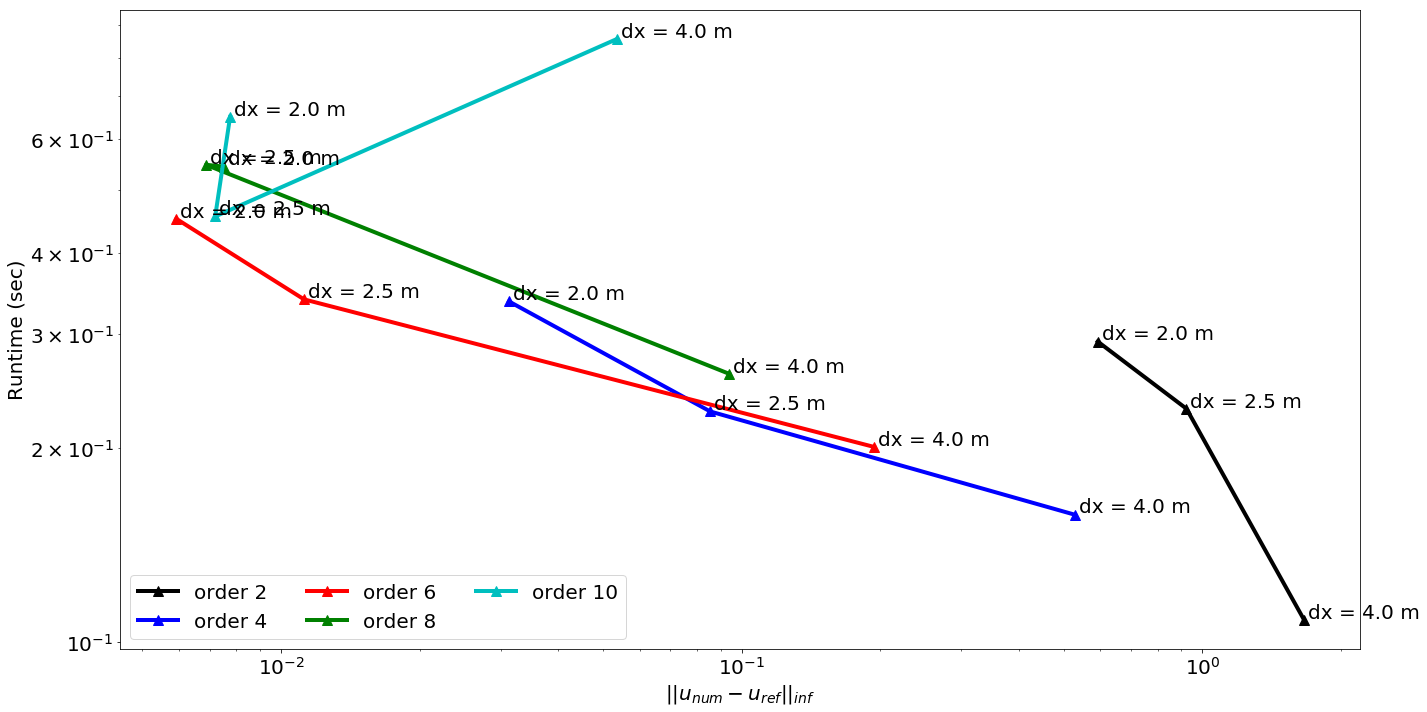

In [16]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

plt.figure(figsize=(20, 10))
for i in range(0, 5):
    plt.loglog(errorl2[i, :], timing[i, :], stylel[i], label=('order %s' % orders[i]), linewidth=4, markersize=10)
    for x, y, a in zip(errorl2[i, :], timing[i, :], [('dx = %s m' % (sc)) for sc in dx]):
                plt.annotate(a, xy=(x, y), xytext=(4, 2),
                             textcoords='offset points', size=20)
plt.xlabel("$|| u_{num} - u_{ref}||_{inf}$", fontsize=20)
plt.ylabel("Runtime (sec)", fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.legend(fontsize=20, ncol=3, fancybox=True, loc='lower left')
plt.savefig("TimeAccuracy.pdf", format='pdf', facecolor='white',
            orientation='landscape', bbox_inches='tight')
plt.show()

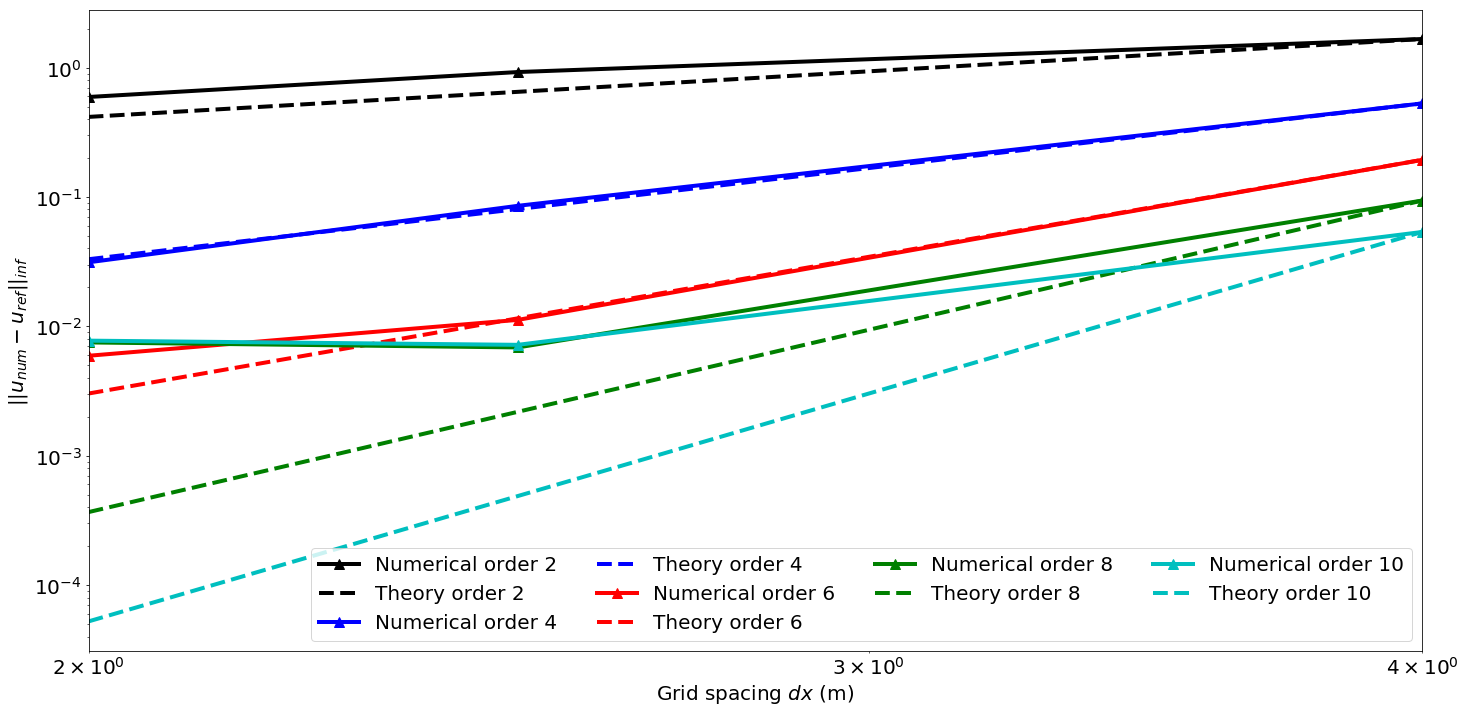

In [17]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

plt.figure(figsize=(20, 10))
for i in range(0, 5):
    theory = [k**(orders[i]) for k in dx]
    theory = [errorl2[i, 2]*th/theory[2] for th in theory]
    plt.loglog([sc for sc in dx], errorl2[i, :], stylel[i], label=('Numerical order %s' % orders[i]),
               linewidth=4, markersize=10)
    plt.loglog([sc for sc in dx], theory, style2[i], label=('Theory order %s' % orders[i]),
               linewidth=4, markersize=10)
#     for x, y, a in zip([sc for sc in dx], errorl2[i, :], [('dx = %s m' % (sc)) for sc in dx]):
#                 plt.annotate(a, xy=(x, y), xytext=(4, 2),
#                              textcoords='offset points', size=20,
#                              horizontalalignment='left', verticalalignment='top')
plt.xlabel("Grid spacing $dx$ (m)", fontsize=20)
plt.ylabel("$||u_{num} - u_{ref}||_{inf}$", fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.legend(fontsize=20, ncol=4, fancybox=True, loc='lower right')
plt.xlim((2.0, 4.0))
plt.savefig("Convergence.pdf", format='pdf', facecolor='white',
            orientation='landscape', bbox_inches='tight')
plt.show()